In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import h5py
import sys
import os
import glob
import warnings
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


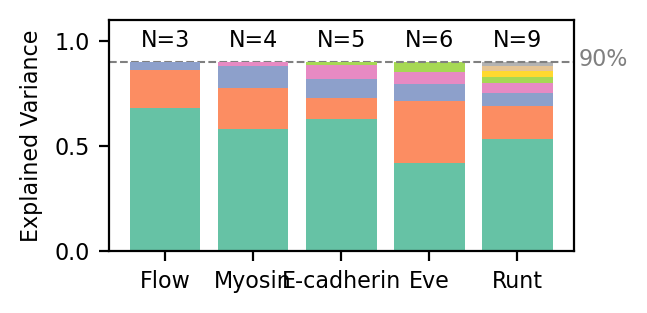

In [21]:
import pickle as pk

plt.rcParams['font.size'] = 8
plt.rcParams['axes.labelsize'] = 8

models = {
    'Flow': 'WT/ECad-GFP/decomposition_models/velocity_SVDPipeline.pkl',
    'Myosin': 'Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP/decomposition_models/tensor_SVDPipeline.pkl',
    'E-cadherin': 'WT/ECad-GFP/decomposition_models/raw_SVDPipeline.pkl',
    'Eve': 'WT/Even_Skipped-YFP/decomposition_models/raw_SVDPipeline.pkl',
    'Runt': 'WT/Runt/decomposition_models/raw_SVDPipeline.pkl',
}
df = pd.DataFrame()
for i, key in enumerate(models.keys()):
    models[key] = pk.load(open(os.path.join('../flydrive', models[key]), 'rb'))
    evr = models[key]['svd'].explained_variance_ratio_
    cum = np.cumsum(evr)
    dfi = pd.DataFrame({'explained_variance': evr, 'total_explained': cum})
    dfi['marker'] = key
    dfi['label'] = i
    df = pd.concat([df, dfi])#df.append(dfi)
df = df.reset_index().rename({'index': 'component'}, axis=1)

fig = plt.figure(figsize=(3, 1.5), dpi=200)
ax = fig.gca()

colors = plt.cm.Set2(np.arange(8)) #Set2 has 8 colors

for i in range(df.component.max()):
    dfi = df[(df.component == i) & (df.total_explained <= 0.9)]
    if len(dfi) == 0: continue
    ax.bar(
        dfi.label,
        dfi.explained_variance, 
        bottom=dfi.total_explained-dfi.explained_variance,
        color=colors[i % len(colors)],
    )
ax.axhline(0.9, color='grey', linestyle='--', lw=.75, zorder=1)
ax.text(1.01, 0.88, '90%', transform=ax.transAxes,
        color='grey', va='top', ha='left')
ax.set(yticks = [0, 0.5, 1], ylim=[0, 1.1], ylabel='Explained Variance')
ax.set_ylabel('Explained Variance')
ax.set(
    xticks = df.label.unique(),
    xticklabels = df.marker.unique(),
)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)

for i in range(df.label.max()+1):
    dfi = df[(df.label == i)].reset_index(drop=True)
    dfn = dfi[dfi.total_explained >= 0.9]
    N = dfn.component.min()
    ax.bar(dfi.label[0], 
           0.9-dfi.total_explained[N-1], 
           bottom=dfi.total_explained[N-1],
           color=colors[N % len(colors)])
    ax.text(i, 0.95, 'N=%d'% (N+1),
            va='bottom', ha='center')

## Myosin PCA data

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 1101.88it/s]


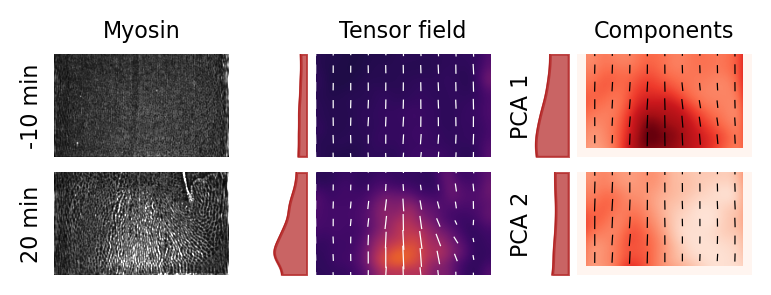

In [55]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.interpolate import interp1d
from morphogenesis.decomposition.decomposition_utils import get_decomposition_model
from morphogenesis.plot_utils import plot_scalar, plot_tensor
from morphogenesis.dataset import *

transform = Reshape2DField()
sqh_dataset = AtlasDataset('Halo_Hetero_Twist[ey53]_Hetero', 'Sqh-GFP', 'tensor2D', transform=transform, drop_time=True, tmin=-15, tmax=45)
model = get_decomposition_model(sqh_dataset)

plt.rcParams['axes.linewidth'] = 0.0

def get_DV_cut(z, N0=80, N1=120):
    if len(z.shape) > 2:
        znorm = np.linalg.norm(z, axis=0)
    else:
        znorm = z
    cut = np.sum(znorm[:, N0:N1], axis=1)
    return cut

def plot_cut(ax, cut, vmin, vmax, color):
    L = cut.shape[0] // 2
    y = np.linspace(*ax.get_ylim(), L)
    ax_Y = ax.inset_axes([-0.25, 0, 0.2, 1], sharey=ax)
    
    ax_Y.plot(cut[:L], y, color=color, lw=0.5)
    ax_Y.fill_betweenx(y, 
                       np.ones(L)*vmin, 
                       cut[:L], 
                       color=color, alpha=0.7)
    ax_Y.set_xlim([vmin, vmax*1.05])
    ax_Y.set(xticks=[], yticks=[])
    ax_Y.invert_xaxis()


eId = 202007011145
df = sqh_dataset.df[sqh_dataset.df.embryoID == eId]
eIdx = df.eIdx.values
sqh = np.load(
    os.path.join(sqh_dataset.path, str(eId), 'tensor2D.npy'),
    mmap_mode='r')[eIdx]
cyt = np.load(
    os.path.join(sqh_dataset.path, str(eId), 'cyt2D.npy'),
    mmap_mode='r')[eIdx]
sqh = sqh.reshape([sqh.shape[0], -1, *sqh.shape[-2:]])
t = df.time.values

    
tmask = np.logical_and(t >= -10, t <= 20)
sqh_norm = np.linalg.norm(sqh[tmask], axis=(1, 2))
vmin = 0
vmax = np.std(sqh_norm)
smin = np.min(cyt[tmask])
smax = smin + 7 * np.std(cyt[tmask])

sqh = interp1d(t, sqh, axis=0)
cyt = interp1d(t, cyt, axis=0)

skip = 20


#Boundary crop
ys, xs = np.where(model['masker'].mask_!=0) 
crop_mask = np.s_[..., min(ys):max(ys)+1, min(xs):max(xs+1)]

#Color maps
cmap='RdPu'
cmap = 'Reds'
color='firebrick'

z = np.eye(model['svd'].n_components)
z[0, 0] = 1
z[1, 1] = 1

mask = model['masker'].mask_
z = model.inverse_transform(z)
znorm = np.linalg.norm(z, axis=1)
zmin = np.min(znorm[..., mask])
zmax = np.max(znorm[..., mask])
lp=12

t = [-10, 20]

fig, ax = plt.subplots(2, 3, figsize=(4.5, 1.5), dpi=200)

pca_cuts, sqh_cuts = [], []
for i in range(2):
    cyt_t = cyt(t[i])
    plot_scalar(ax[i, 0], cyt_t, vmin=smin, vmax=smax, cmap='Greys_r')
    
    sqh_t = sqh(t[i])
    plot_tensor(ax[i, 1], sqh_t, 
                  vmin=vmin, vmax=vmax)
    sqh_cuts.append(get_DV_cut(sqh_t, 100, 180))
    
    ax[i, 0].set_ylabel(f'{t[i]} min')
    
    plot_tensor(ax[i, 2], z[i], cmap=cmap, 
                  linecolor='black',
                  vmin=zmin, vmax=zmax)
    pca_cuts.append(get_DV_cut(z[i][crop_mask], 60, 120))
    ax[i, 2].set_ylabel(f'PCA {i+1}', labelpad=16)
    
pca_cuts = np.stack(pca_cuts)
sqh_cuts = np.stack(sqh_cuts)
for i in range(2):
    plot_cut(ax[i, 1], sqh_cuts[i], 0.2*sqh_cuts.max(), sqh_cuts.max(), color=color)
    plot_cut(ax[i, 2], pca_cuts[i], 0.2*pca_cuts.max(), pca_cuts.max(), color=color)
    
ax[0, 0].set_title('Myosin')
ax[0, 1].set_title('Tensor field')
ax[0, 2].set_title('Components')

fig.subplots_adjust(wspace=0.5, hspace=0.05)

int64


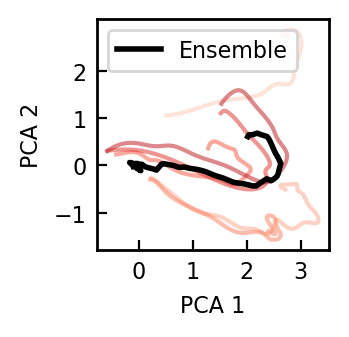

In [56]:
from scipy.interpolate import splprep, splev

plt.rcParams['axes.linewidth'] = 1
df = pd.read_csv(f'{sqh_dataset.path}/decomposition_models/tensor_SVDPipeline.csv')

tmin, tmax = -15, 30
df = df[(df.t >= tmin) & (df.t <= tmax)]

fig, ax = plt.subplots(1, 1, figsize=(1.5, 1.5), dpi=200)

colors = plt.cm.plasma(np.linspace(0, 1, len(df.embryoID.unique())))
colors = plt.cm.Reds(np.linspace(0.2, 0.8, len(df.embryoID.unique())))

for i, embryoID in enumerate(df.embryoID.unique()):
    data = df[df.embryoID == embryoID].sort_values('t')
    data = data.loc[:, ['param0', 'param1']]
    data = data.drop_duplicates()
    x = data.param0.values
    y = data.param1.values
    
    #Smooth using spline interpolant in between timepoints
    f, _ = splprep([x, y], s=.02)
    x, y, = splev(np.linspace(0, 1, 100), f)
    ax.plot(x, y, c=colors[i], alpha=0.5)

df['t'] = np.round(df['t'])
print(df.t.dtype)
data = df.groupby('t').agg({'param0': 'mean', 'param1': 'mean'}).reset_index()
t = np.linspace(tmin, tmax, 100)
p0 = interp1d(data.t, data.param0, fill_value='extrapolate')
p1 = interp1d(data.t, data.param1, fill_value='extrapolate')
ax.plot(p0(t), p1(t),
        color='black', lw=2, label='Ensemble')

ax.set(xticks=[0, 1, 2, 3], yticks=[-1, 0, 1, 2],
       xlabel='PCA 1',
       ylabel='PCA 2')
ax.legend(loc='upper left')

## Flow PCA data

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 927.23it/s]


ValueError: need at least one array to stack

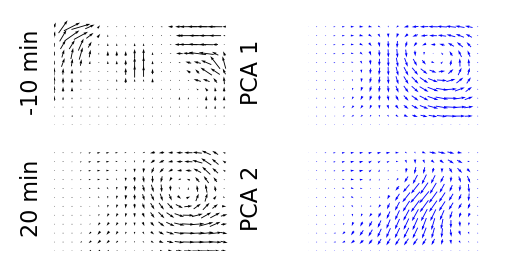

In [86]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.interpolate import interp1d
from morphogenesis.decomposition.decomposition_utils import get_decomposition_model
from morphogenesis.plot_utils import plot_vector
from morphogenesis.dataset import *

transform = Reshape2DField()
sqh_dataset = AtlasDataset('Halo_Hetero_Twist[ey53]_Hetero', 'Sqh-GFP', 'velocity2D', transform=transform, drop_time=True, tmin=-15, tmax=45)
model = get_decomposition_model(sqh_dataset)

plt.rcParams['axes.linewidth'] = 0.0


eId = 202007011145
df = sqh_dataset.df[sqh_dataset.df.embryoID == eId]
eIdx = df.eIdx.values
vel = np.load(
    os.path.join(sqh_dataset.path, str(eId), 'velocity2D.npy'),
    mmap_mode='r')[eIdx]
t = df.time.values

vel = interp1d(t, vel, axis=0)

skip = 20


#Boundary crop
ys, xs = np.where(model['masker'].mask_!=0) 
crop_mask = np.s_[..., min(ys):max(ys)+1, min(xs):max(xs+1)]

#Color maps
cmap='RdPu'
cmap = 'Reds'
color='firebrick'

z = np.eye(model['svd'].n_components)
z[0, 0] = 1
z[1, 1] = 1

mask = model['masker'].mask_
z = model.inverse_transform(z)
znorm = np.linalg.norm(z, axis=1)
zmin = np.min(znorm[..., mask])
zmax = np.max(znorm[..., mask])
lp=12

t = [-10, 20]

fig, ax = plt.subplots(2, 2, figsize=(3, 1.5), dpi=200)

pca_cuts, sqh_cuts = [], []
for i in range(2):
    
    vel_t = vel(t[i])
    plot_vector(ax[i, 0], vel_t)
    
    ax[i, 0].set_ylabel(f'{t[i]} min')
    
    plot_vector(ax[i, 1], z[i], color='blue')
    pca_cuts.append(get_DV_cut(z[i][crop_mask], 60, 120))
    ax[i, 1].set_ylabel(f'PCA {i+1}', labelpad=16)
    
ax[0, 0].set_title('Flow')
ax[0, 1].set_title('Tensor field')
ax[0, 2].set_title('Components')

fig.subplots_adjust(wspace=0.5, hspace=0.05)

int64


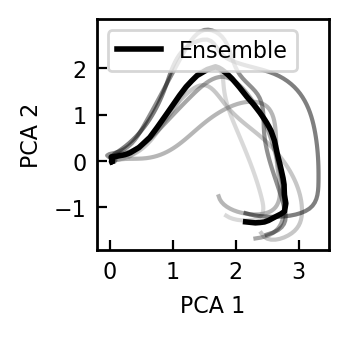

In [79]:
from scipy.interpolate import splprep, splev

plt.rcParams['axes.linewidth'] = 1
df = pd.read_csv(f'{sqh_dataset.path}/decomposition_models/velocity_SVDPipeline.csv')

tmin, tmax = -15, 30
df = df[(df.t >= tmin) & (df.t <= tmax)]

fig, ax = plt.subplots(1, 1, figsize=(1.5, 1.5), dpi=200)

colors = plt.cm.Greys(np.linspace(0.4, 1.0, len(df.embryoID.unique())))

for i, embryoID in enumerate(df.embryoID.unique()):
    data = df[df.embryoID == embryoID].sort_values('t')
    data = data.loc[:, ['param0', 'param1']]
    data = data.drop_duplicates()
    x = data.param0.values
    y = data.param1.values
    
    #Smooth using spline interpolant in between timepoints
    f, _ = splprep([x, y], s=.02)
    x, y, = splev(np.linspace(0, 1, 100), f)
    ax.plot(x, y, c=colors[i], alpha=0.5)

df['t'] = np.round(df['t'])
print(df.t.dtype)
data = df.groupby('t').agg({'param0': 'mean', 'param1': 'mean'}).reset_index()
t = np.linspace(tmin, tmax, 100)
p0 = interp1d(data.t, data.param0, fill_value='extrapolate')
p1 = interp1d(data.t, data.param1, fill_value='extrapolate')
ax.plot(p0(t), p1(t),
        color='black', lw=2, label='Ensemble')

ax.set(xticks=[0, 1, 2, 3], yticks=[-1, 0, 1, 2],
       xlabel='PCA 1',
       ylabel='PCA 2')
ax.legend(loc='upper left')

## eCad PCA data

100%|██████████| 6/6 [00:00<00:00, 939.37it/s]


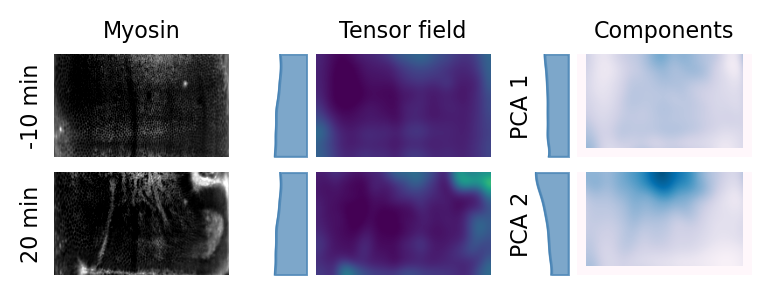

In [62]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.interpolate import interp1d
from morphogenesis.decomposition.decomposition_utils import get_decomposition_model
from morphogenesis.plot_utils import plot_scalar, plot_tensor
from morphogenesis.dataset import *
from torchvision.transforms import Compose

transform = Reshape2DField()
cad_dataset = AtlasDataset('WT', 'ECad-GFP', 'raw2D',
                           transform=Compose([transform, Smooth2D(sigma=7)]))
model = get_decomposition_model(cad_dataset)

plt.rcParams['axes.linewidth'] = 0.0

def get_DV_cut(z, N0=40, N1=120):
    if len(z.shape) > 2:
        znorm = np.linalg.norm(z, axis=0)
    else:
        znorm = z
    cut = np.sum(znorm[:, N0:N1], axis=1)
    return cut

def plot_cut(ax, cut, vmin, vmax, color):
    L = cut.shape[0] // 2
    y = np.linspace(*ax.get_ylim(), L)
    ax_Y = ax.inset_axes([-0.25, 0, 0.2, 1], sharey=ax)
    
    ax_Y.plot(cut[:L], y, color=color, lw=0.5)
    ax_Y.fill_betweenx(y, 
                       np.ones(L)*vmin, 
                       cut[:L], 
                       color=color, alpha=0.7)
    ax_Y.set_xlim([vmin, vmax*1.05])
    ax_Y.set(xticks=[], yticks=[])
    ax_Y.invert_xaxis()


eId = 202001280915
df = cad_dataset.df[cad_dataset.df.embryoID == eId]
eIdx = df.eIdx.values
cad = np.load(
    os.path.join(cad_dataset.path, str(eId), 'raw2D.npy'),
    mmap_mode='r')[eIdx]
t = df.time.values

    
tmask = np.logical_and(t >= -10, t <= 20)
vmin = np.median(cad[tmask]) - np.std(cad[tmask])
vmax = vmin + 7 * np.std(cad[tmask])

cad = interp1d(t, cad, axis=0)

skip = 20

#Boundary crop
ys, xs = np.where(model['masker'].mask_!=0) 
crop_mask = np.s_[..., min(ys):max(ys)+1, min(xs):max(xs+1)]

#Color maps
cmap='PuBu'
color='steelblue'

z = np.eye(model['svd'].n_components)
z[0, 0] = 1
z[1, 1] = 1

mask = model['masker'].mask_
z = model.inverse_transform(z)
znorm = np.linalg.norm(z, axis=1)
zmin = np.min(znorm[..., mask])
zmax = np.max(znorm[..., mask])
lp=12

t = [-10, 20]

fig, ax = plt.subplots(2, 3, figsize=(4.5, 1.5), dpi=200)

pca_cuts, cad_cuts = [], []
for i in range(2):
    cad_t = cad(t[i])
    plot_scalar(ax[i, 0], cad_t, vmin=vmin, vmax=vmax, cmap='Greys_r')
    
    cad_t = Smooth2D(sigma=7)(cad_t[None])
    plot_scalar(ax[i, 1], cad_t, 
                  vmin=vmin, vmax=vmax)
    sqh_cuts.append(get_DV_cut(sqh_t, 100, 180))
    
    ax[i, 0].set_ylabel(f'{t[i]} min')
    
    plot_scalar(ax[i, 2], z[i], cmap=cmap, 
                  vmin=zmin, vmax=zmax)
    pca_cuts.append(get_DV_cut(z[i][crop_mask], 60, 120))
    ax[i, 2].set_ylabel(f'PCA {i+1}', labelpad=16)
    
pca_cuts = np.stack(pca_cuts)
sqh_cuts = np.stack(sqh_cuts)
for i in range(2):
    plot_cut(ax[i, 1], sqh_cuts[i], 0.2*sqh_cuts.max(), sqh_cuts.max(), color=color)
    plot_cut(ax[i, 2], pca_cuts[i], 0.2*pca_cuts.max(), pca_cuts.max(), color=color)
    
ax[0, 0].set_title('Myosin')
ax[0, 1].set_title('Tensor field')
ax[0, 2].set_title('Components')

fig.subplots_adjust(wspace=0.5, hspace=0.05)

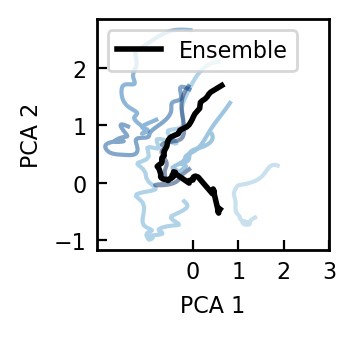

In [76]:
from scipy.interpolate import splprep, splev

plt.rcParams['axes.linewidth'] = 1
df = pd.read_csv(f'{cad_dataset.path}/decomposition_models/raw_SVDPipeline.csv')

tmin, tmax = -15, 30
df = df[(df.t >= tmin) & (df.t <= tmax)]

fig, ax = plt.subplots(1, 1, figsize=(1.5, 1.5), dpi=200)

colors = plt.cm.Blues(np.linspace(0.4, 1.0, len(df.embryoID.unique())))

for i, embryoID in enumerate(df.embryoID.unique()):
    data = df[df.embryoID == embryoID].sort_values('t')
    data = data.loc[:, ['param0', 'param1']]
    data = data.drop_duplicates()
    x = data.param0.values
    y = data.param1.values
    
    #Smooth using spline interpolant in between timepoints
    f, _ = splprep([x, y], s=.05)
    x, y, = splev(np.linspace(0, 1, 100), f)
    ax.plot(x, y, c=colors[i], alpha=0.5)

df['t'] = np.round(df['t'])
data = df.groupby('t').agg({'param0': 'mean', 'param1': 'mean'}).reset_index()
t = np.linspace(tmin, tmax, 100)
p0 = interp1d(data.t, data.param0, fill_value='extrapolate')
p1 = interp1d(data.t, data.param1, fill_value='extrapolate')
ax.plot(p0(t), p1(t),
        color='black', lw=2, label='Ensemble')

ax.set(xticks=[0, 1, 2, 3], yticks=[-1, 0, 1, 2],
       xlabel='PCA 1',
       ylabel='PCA 2')
ax.legend(loc='upper left')